# Your First Convolutional Neural Network (CNN)

#### By: Jenna Everard

*Last Updated: September 22nd, 2024*

## An Introduction to Machine Learning

In [ ]:
# TO DO

## What is a Convolutional Neural Network?

![Figure 1](Figures/Neural_Network_vs_Neuron.png)

In [ ]:
# TO DO

## Introduction to the Tutorial

In this tutorial, you will learn how to set up a convolutional neural network in python, train the model on a training dataset, and then use it to predict unseen data! Our task in this basic introduction will be to classify images. Our training data will come from the Intel Image Classification dataset (Source: https://www.kaggle.com/datasets/puneet6060/intel-image-classification?resource=download). This data was published by Intel as part of an Image classification challenge they hosted and is publicly available online for use in education.

The dataset constains around 25,000 total images of size 150 pixels by 150 pixels. The images are split into 6 different categories:

0. Buildings
1. Forest
2. Glacier
3. Mountain
4. Sea
5. Street

If you were to access the data yourself at the link provided, you may find that Intel has already split the data into training, testing, and predicting subsets (Don't worry if you don't know what this means - we'll go over it soon!). To provide the full experience of creating your own dataset and training your model, I've merged the training and testing subsets so that you can see how to construct your own splits. Additionally, the version of this dataset provided in this repository is an abridged version due to file size limits of GitHub (and due to the fact I'm currently living on a scientific ocean drilling vessel in the middle of the Pacific Ocean and don't have the strongest connection). If you want the full dataset, it's available at the link above!

Throughout the tutorial, you'll see interspersed paragraphs in green text. These paragraphs have been included to attempt to better explain the code line-by-line in a way that I hope is more understandable for the beginner programmer. If you are proficient in Python already, feel free to skip these bits - you won't miss any information!

With that, let's begin!

## Building our Image Classification Model

### Step 1: Importing the necessary packages

<span style="color:green">
    In Python, many different functions (i.e. taking the square root of a number, finding the distance between two geographic points) have already been implemented by others. Rather than implementing them ourselves, we can import these functions that others have published as packages. Python packages are a great way to increase code reusability, efficiency, and community support - you can think of them like your mini toolboxes!
</span>

The following are the packages we will require throughout the remainder of this Jupyter Notebook. These import statements will add the pacakges' functionalities to your working space; however, if you don't have a package installed you will first need to create a new code cell and run:

```
pip install package_name
```

In [44]:
# os provides support for navigating file systems
import os

# PIL provides easy functions for displaying, formatting, and saving images
from PIL import Image

# numpy provides support for arrays and mathematical functions
# pandas is built on top of numpy and is used for structured data manipulation and analysis
import numpy as np
import pandas as pd

# pyplot (part of matplotlib) is my preferred graphing and visualization package
import matplotlib.pyplot as plt

# scikit-learn is a machine learning library for data mining and predictive functions
from sklearn.metrics         import accuracy_score
from sklearn.model_selection import train_test_split

# Tensorflow is an open-source library from google for building and training ML models
import tensorflow as tf

# Keras is a high-level API that runs on top of tensorflow
# Keras provides a more intuitive way to build and train neural networks
import keras
from keras.models import Model
from keras.utils  import to_categorical
from keras.layers import Dense, Conv2D, MaxPooling2D, Input, Conv2DTranspose, concatenate, BatchNormalization, ReLU, Flatten

### Step 2: Load in the Data

First, download the data from the repository and unzip all of the sub-folders.

Then we need to specify the directory path of this folder.

In [4]:
# UPDATE to your correct directory that contains the image folders
path = 'mini_intel_classification_data/'

Before we load in the images, we need the name of each image file in each directory. For this we'll use the os package to get an inventory of each folder.

In [5]:
building_file_names = [f.split('.')[0] for f in os.listdir(path + '/buildings/') if f.endswith('.jpg')]
forest_file_names = [f.split('.')[0] for f in os.listdir(path + '/forest/') if f.endswith('.jpg')]
glacier_file_names = [f.split('.')[0] for f in os.listdir(path + '/glacier/') if f.endswith('.jpg')]
mountain_file_names = [f.split('.')[0] for f in os.listdir(path + '/mountain/') if f.endswith('.jpg')]
sea_file_names = [f.split('.')[0] for f in os.listdir(path + '/sea/') if f.endswith('.jpg')]
street_file_names = [f.split('.')[0] for f in os.listdir(path + '/street/') if f.endswith('.jpg')]

<span style="color:green">
    The above code is a short hand version. The full length write-up for just getting the building file names would be:
</span>

```
building_file_names = []
for f in os.listdir(path + '/buildings/'):
    if f.endswith('.jpg'):
        name = f.split('.')
        name = name[0]
        building_file_names.append(name)
```

<span style="color:green">
    Essentially we're making an array/list of all the file names. We start a for loop to iterate over each file name in the buildings sub-folder (as returned by an os function). We then verify it's an image with our if statement - the indented three lines below it will not run if the file is not an image. We then split the file name at the full stop which convers the file name into an array where the zeroeth element (remember - python is zero-indexed!) is the name and the first element is the extension (.jpg). We then add the name to our running list of file names.
</span>

Now we'll define a function for reading in our images and apply it. The following function takes as inputs the name of the files to read and the image sizes. It returns an image stack as a two-dimensional array.

In [6]:
def read_images(names, size, subfolder):
    
    img_array = []
    
    for file in names:
        file_path = os.path.join(path + subfolder + file + '.jpg')
        file = Image.open(file_path).convert('RGB')
        file = file.resize(size)
        file_array = np.array(file)
        img_array.append(file_array)
        
    return np.array(img_array) / 255

<span style="color:green">
    Let's break down that function. We begin by initializing an empty image array for all our images that we are going to read. We then use a for loop to iterate through each file name, using the os package to create a path from that file name. We then use the PIL package to open the image and re-size it into a numpy array. On each iteration we append an image to our array of images, forming a numpy array with the dimensions (number of images, image height, image width)
</span>

In [7]:
building_files = read_images(building_file_names, (150,150), 'buildings/')
forest_files = read_images(forest_file_names, (150,150), 'forest/')
glacier_files = read_images(glacier_file_names, (150,150), 'glacier/')
mountain_files = read_images(mountain_file_names, (150,150), 'mountain/')
sea_files = read_images(sea_file_names, (150,150), 'sea/')
street_files = read_images(street_file_names, (150,150), 'street/')

### Step 3: Prepare Image Data

We need even dimensions (not 150x150, so we're going to pad a five pixel border around each image. Numpy has an np.pad function we can use where we specify the top, bottom, right, and left pad width (and then 0 for the third RGB dimension since we're not altering that). If your images already had an even dimension, then you wouldn't need to do this step!

In [8]:
def pad_5px(images, shape = (150,150)):
    padded_images = []
    for image in images:
        padded_img = np.pad(image, pad_width=((5,5),(5,5),(0,0)),mode='constant', constant_values = 0)
        padded_images.append(padded_img)
    return np.array(padded_images)

In [9]:
building_files = pad_5px(building_files)
forest_files = pad_5px(forest_files)
glacier_files = pad_5px(glacier_files)
mountain_files = pad_5px(mountain_files)
sea_files = pad_5px(sea_files)
street_files = pad_5px(street_files)

Here we'll quickly visualize some of the images we have:

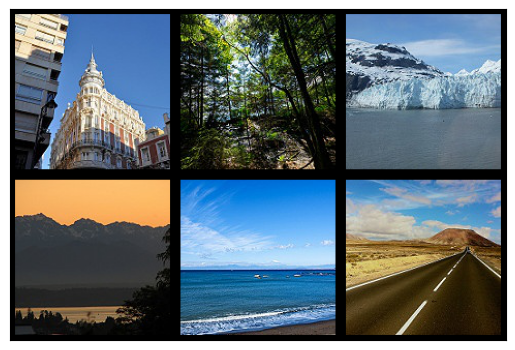

In [10]:
# The following code merges a bunch of images together to view in one plt.imshow call
# It is not necessary to understand its functioning in order to complete this tutorial
mega_img = np.zeros((160*2,160*3,3))
mega_img[0:160,0:160] = building_files[75,:]
mega_img[0:160,160:160*2] = forest_files[75,:]
mega_img[0:160,160*2:160*3] = glacier_files[75,:]
mega_img[160:160*2, 0:160] = mountain_files[75,:]
mega_img[160:160*2, 160:160*2] = sea_files[75,:]
mega_img[160:160*2, 160*2:160*3] = street_files[75,:]
plt.xticks([])
plt.yticks([])
plt.imshow(mega_img) 

To finish preparing the input image data, we'll combine all six of the different image class arrays into one array.

In [11]:
input_images = np.concatenate((building_files, forest_files, glacier_files, 
                               mountain_files, sea_files, street_files), axis=0)
print(input_images.shape)

(9566, 160, 160, 3)


<span style="color:green">
    The numpy package provides us with a function for concatenating our image arrays. We specify that we'd like to concatenate on axis 0, meaning the 0-th dimension of our image arrays. As a refresher, the dimensions of our image arrays are as follows - 0: number of images; 1: image height; 2: image width; 3: pixel channels (for RGB this is 3). Concatenating along axis 0 means that is the dimension that will change as we add more images.
</span>

### Step 4: Prepare Label Data

Since this data is training data, we know what image class each image belongs to - it's the sub-folder that each image was in! We also need to give our model this so-called "label information" when we train it. A straightforward way to do that is to create a 1D numpy array of length equal to the total number of images. We know what order we added our training images to our larger input array, so we can add the labels in the same order, adding the label number for each image that label corresponds to (i.e. if I have 10 building images (label 0), I would add the integer 0 to my label array 10 times).

In [12]:
input_labels = np.zeros(len(building_file_names))
input_labels = np.concatenate((input_labels, np.zeros(len(forest_file_names))+1))
input_labels = np.concatenate((input_labels, np.zeros(len(glacier_file_names))+2))
input_labels = np.concatenate((input_labels, np.zeros(len(mountain_file_names))+3))
input_labels = np.concatenate((input_labels, np.zeros(len(sea_file_names))+4))
input_labels = np.concatenate((input_labels, np.zeros(len(street_file_names))+5))
input_labels = np.array(input_labels)

print(input_labels.shape)

(9566,)


<span style="color:green">
    np.zeros is a shortcut function that allows us to create an array of zeros of the specified length. Above, I use it to create zero-arrays of the same length as each image array (equal to the number of image names in that sub-folder). I can then just add the value of the label to its respective zero-array and concatenate them all together. Printing out the shape of the label array we just made verifies that it is indeed a 1D array and it has the same length as the number of images (the dimension of our zeroeth axis of the input array)
</span>

Computers think in binary - 0's and 1's - and so we're going to put our labels into a binary-esque format known as one-hot encoding. Essentially, our numbering system here is, since we have 6 classes, class one is 100000, class two is 010000, class three is 001000 and so on. Encoding our label data in this manner allows for better performance and stability and reduces ambiguity - for example, if we just used 0,1,2,3 etc, a computer may assume a hierarchical relationship, which is not necessarily true or valid!

Luckily Keras provides us with an easy function to do this: to_categorical.

In [13]:
num_classes = 6

train_labels_categorical = []
for label in input_labels:
    train_labels_categorical.append(to_categorical(label, num_classes=num_classes))
train_labels_categorical = np.array(train_labels_categorical)

### Step 5: Split into Training and Validation Data

Now, we must split our data into two subsets:

**1. Training Data:** These are the images and corresponding labels that our model will use to update its function weights as it is training and trying to reach the greatest accuracy

**2. Validation Data:** On each iteration of training, these are the images our model will take once it has finished updating its weights. It will predict the class for these images and then compare it to their corresponding labels to generate a measure of its current accuracy at that iteration. This will inform how the weights are updated upon the next iteration.

The percentage of your data that goes into each set depends on the context of your modeling and your total data size. However, a common split - and the one we'll use here - is 75% is set as training data and 25% is set as validation data.

This is another task we don't have to code ourself! Rather, we can sci-kit-learn's function: train_test_split

In [14]:
X_train, X_val, y_train, y_val = train_test_split(input_images, train_labels_categorical, test_size=0.25, random_state=42)

### Step 6: Define Model

NOTE: FROM THIS POINT ON THERE ARE NOT MANY EXPLANATIONS - I haven't finished this part of the tutorial except for the code

We're going to base our model on the U-Net Architecture ("U-Net: Convolutional Networks for Biomedical Image Segmentation", Ronneberger et. al., 2015). 

![Figure 2](Figures/U-Net_Architecture.png)

In [15]:
inputs = Input((160, 160, 3))

#Contraction path
c1 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = BatchNormalization()(c1)
c1 = ReLU()(c1)
c1 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
c1 = BatchNormalization()(c1)
c1 = ReLU()(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = BatchNormalization()(c2)
c2 = ReLU()(c2)
c2 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
c2 = BatchNormalization()(c2)
c2 = ReLU()(c2)
p2 = MaxPooling2D((2, 2))(c2)
 
c3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = BatchNormalization()(c3)
c3 = ReLU()(c3)
c3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
c3 = BatchNormalization()(c3)
c3 = ReLU()(c3)
p3 = MaxPooling2D((2, 2))(c3)
 
c4 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = BatchNormalization()(c4)
c4 = ReLU()(c4)
c4 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
c4 = BatchNormalization()(c4)
c4 = ReLU()(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = BatchNormalization()(c5)
c5 = ReLU()(c5)
c5 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
c5 = BatchNormalization()(c5)
c5 = ReLU()(c5)

#Expansive path 
u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
u6 = BatchNormalization()(u6)
u6 = ReLU()(u6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u6)
u7 = concatenate([u7, c3])
u7 = BatchNormalization()(u7)
u7 = ReLU()(u7)
 
u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u7)
u8 = concatenate([u8, c2])
u8 = BatchNormalization()(u8)
u8 = ReLU()(u8)
 
u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(u8)
u9 = concatenate([u9, c1], axis=3)
u9 = BatchNormalization()(u9)
u9 = ReLU()(u9)

u10 = Flatten()(u9)

 
outputs = Dense(num_classes, activation='softmax')(u10)

In [16]:
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Step 7: Train Model

In [17]:
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=256, epochs=15, verbose=1)

Epoch 1/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 120s 4s/step - accuracy: 0.2822 - loss: 54.8954 - val_accuracy: 0.2195 - val_loss: 7.4863
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 106s 4s/step - accuracy: 0.5825 - loss: 9.0984 - val_accuracy: 0.3332 - val_loss: 2.7378
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 105s 4s/step - accuracy: 0.7055 - loss: 2.5548 - val_accuracy: 0.3625 - val_loss: 1.7675
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 105s 4s/step - accuracy: 0.8065 - loss: 1.1501 - val_accuracy: 0.3315 - val_loss: 1.8243
Epoch 5/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step - accuracy: 0.7254 - loss: 2.2442 - val_accuracy: 0.4151 - val_loss: 1.7585
Epoch 6/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.8745 - loss: 0.5697 - val_accuracy: 0.4348 - val_loss: 1.8314
Epoch 7/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step - accuracy: 0.9370 - loss: 0.2027 - val_accuracy: 0.4523 - val_loss: 1.8400
Epoch 8/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step - accuracy: 0.9879 - loss: 0.0521 - val_accuracy: 0.4712 - 

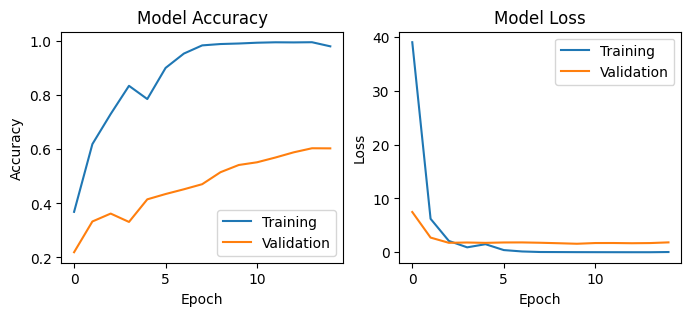

In [60]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].plot(accuracy, label='Training')
axs[0].plot(val_accuracy, label='Validation')
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='lower right')

axs[1].plot(loss, label='Training')
axs[1].plot(val_loss, label='Validation')
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper right')

plt.show()

Note: Ideally, you'd want to keep training it. You want the val_accuracy to be like 90%. This can be accomplished by increasing epochs or playing around with batch size (there are pros and cons to both small and large batch sizes)

### Step 8: Test Model on Unknowns

In [21]:
to_predict = read_images(['52', '400', '64', '949'], (150,150), 'to_predict/')

In [22]:
to_predict = pad_5px(to_predict)

In [24]:
results = model.predict(to_predict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Quick explanation of the following line: essentially model.predict returns an array of six numbers for each image. Those numbers correspond to the probability that it's labels 1-6 (0-5 in 0-indexing of python). We use np.argmax to find index of biggest number - that index is the label according to the CNN!

In [34]:
resulting_labels = np.argmax(results, axis=1)

In [37]:
label_dictionary = {0: 'Building',
                   1: 'Forest',
                   2: 'Glacier',
                   3: 'Mountain',
                   4: 'Sea',
                   5: 'Street'}

Text(0.5, 1.0, 'Predicted Class: Building')

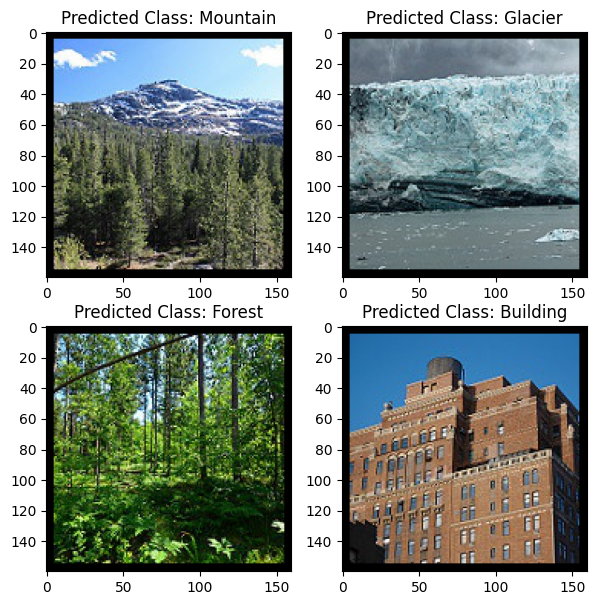

In [55]:
fig, axs = plt.subplots(2,2, figsize=(7,7))

axs[0,0].imshow(to_predict[0,:])
axs[0,0].set_title('Predicted Class: ' + label_dictionary[resulting_labels[0]])

axs[0,1].imshow(to_predict[1,:])
axs[0,1].set_title('Predicted Class: ' + label_dictionary[resulting_labels[1]])

axs[1,0].imshow(to_predict[2,:])
axs[1,0].set_title('Predicted Class: ' + label_dictionary[resulting_labels[2]])

axs[1,1].imshow(to_predict[3,:])
axs[1,1].set_title('Predicted Class: ' + label_dictionary[resulting_labels[3]])

Yay!